In [2]:
pip install opencv-python easyocr

Note: you may need to restart the kernel to use updated packages.


In [17]:

import matplotlib.pyplot as plt


In [15]:
pip install koreanize-matplotlib

     ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
     - -------------------------------------- 0.3/7.9 MB 9.9 MB/s eta 0:00:01
     --- ------------------------------------ 0.8/7.9 MB 9.8 MB/s eta 0:00:01
     ------ --------------------------------- 1.3/7.9 MB 10.4 MB/s eta 0:00:01
     ---------- ----------------------------- 2.0/7.9 MB 11.7 MB/s eta 0:00:01
     -------------- ------------------------- 2.9/7.9 MB 13.2 MB/s eta 0:00:01
     -------------------- ------------------- 4.0/7.9 MB 15.0 MB/s eta 0:00:01
     -------------------------- ------------- 5.3/7.9 MB 17.0 MB/s eta 0:00:01
     --------------------------------- ------ 6.6/7.9 MB 18.4 MB/s eta 0:00:01
     ---------------------------------------  7.9/7.9 MB 19.5 MB/s eta 0:00:01
     ---------------------------------------- 7.9/7.9 MB 18.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


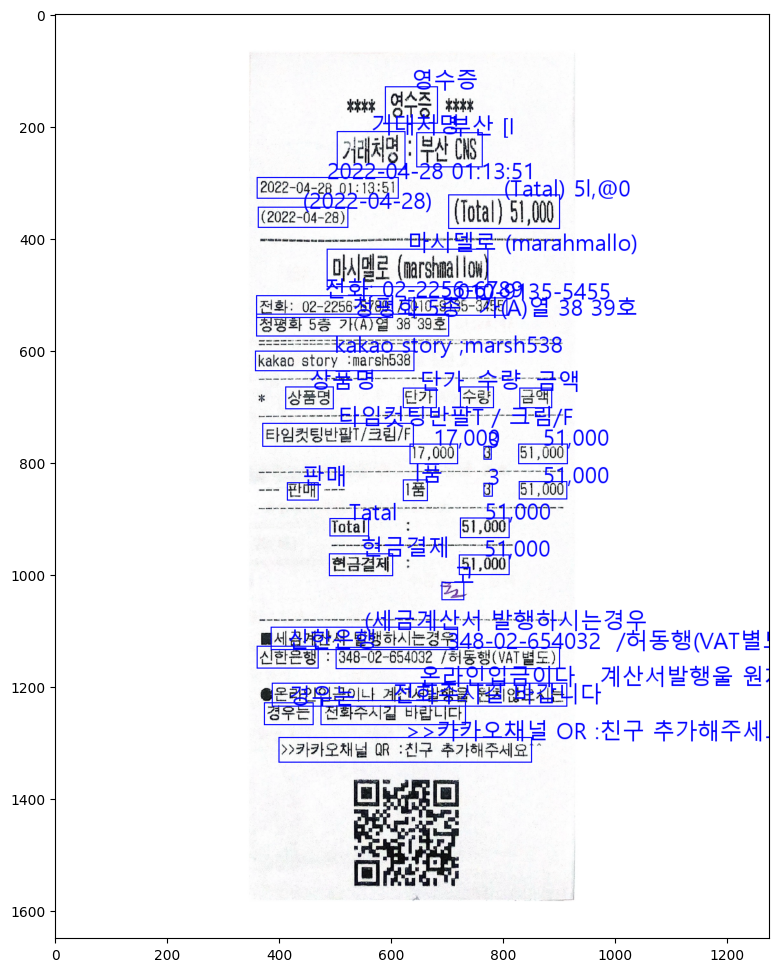

In [4]:
import cv2
import easyocr
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

reader = easyocr.Reader(['ko', 'en'])
result =  reader.readtext('/Users/402-07/YoungMan_projectDE/receipt_list/01.jpg')

img = cv2.imread('/Users/402-07/YoungMan_projectDE/receipt_list/01.jpg')

img = Image.fromarray(img)
font = ImageFont.truetype("malgun.ttf", 40)
draw = ImageDraw.Draw(img)

for i in result:
  x = i[0][0][0]
  y = i[0][0][1]
  w = i[0][1][0] - i[0][0][0]
  h = i[0][2][1] - i[0][1][1]

  draw.rectangle(((x, y), (x+w, y+h)), outline="blue", width=2)
  draw.text((int((x+x+w)/2), y-40), str(i[1]), font=font, fill="blue")

plt.figure(figsize=(15, 12))
plt.imshow(img)
plt.show()

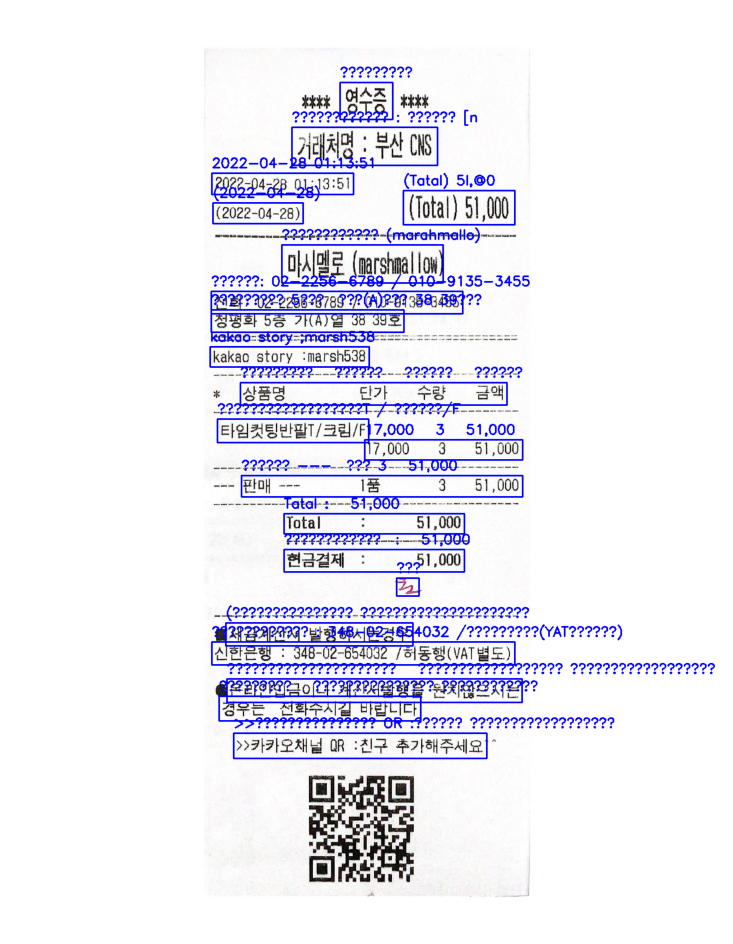

In [16]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import koreanize_matplotlib

reader = easyocr.Reader(['en', 'ko']) 

image_path = '/Users/402-07/YoungMan_projectDE/receipt_list/01.jpg' 
image = cv2.imread(image_path)

results = reader.readtext(image_path, width_ths = 15, ycenter_ths = 0.5)

# 탐지된 결과를 바탕으로 박스 경계 생성
for (bbox, text, prob) in results:
    # 경계 상자의 좌표 추출
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

    # 이미지에 상자 그리기
    cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    # 이미지에 텍스트 쓰기
    cv2.putText(image, text, (top_left[0], top_left[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# 경계 상자와 텍스트가 그려진 이미지를 표시
plt.figure(figsize=(15, 12))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 축 숨기기
plt.show()

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# 한글 부분을 easyOCR은 인식하지만 matplotlib에서 인코딩을 못 하는 것으로 추정됨
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [2]:
import easyocr

text_lists = []
update_text = []
json_text = [] 

def extract_text_from_image(image_path, languages=['en', 'ko']):
    global update_text

    # OCR 리더 초기화
    reader = easyocr.Reader(languages)

    blocked_characters = 'COUBJu니<{}>|]\:[_+=`!@~#$%^&*)(?;\"\''
    # 이미지 파일에서 텍스트 추출
    # 황금비율  width_ths = 15, ycenter_ths = 0.5
    result = reader.readtext(image_path, width_ths = 15, ycenter_ths = 0.5, blocklist=blocked_characters)

    flag = False
    list = []

    # 추출된 텍스트 출력
    for detection in result:
        print(detection[1])

    for (bbox, text, prob) in result:
            list.append(text)
    
    for text in list:
        if flag and ("판매소계" in text or "판매" in text or "판매량" in text or "만" in text or "판" in text or "민" in text or "소계" in text):
            break
        if flag:
            text_lists.append(text)
        if "금액" in text or "수량" in text or "단가" in text:
            flag = True
        

    # 텍스트를 추출할 때,  width_ths = 15, ycenter_ths = 0.5 의 비율로 박스를 조정하면 [품명, 단가 수량 금액] 별로 나온다.
    # 품명은 문제 없지만, 단가 수량 금액을 따로 딕셔너리로 바꾸려면 공백을 기준으로 split을 해야함.
    # 그래서 다음 코드는 짝수번째에 해당하는 배열은 그대로 두고 홀수번째에 해당하는 배열을 조정하는 것이다.
    dt = {}
    flag2 = False

    if("," in text_lists[0] or "." in text_lists[0]) :
        flag2 = True

    for i in range(0, len(text_lists)):
        if(flag2) :
            result_text = text_lists[i].split()
            if(len(result_text) == 4) :
                dt['품목'] = result_text[0]
                dt['단가'] = result_text[1].replace("I", "1")
                dt['수량'] = result_text[2]
                dt['금액'] = result_text[3] 
                json_text.append(dt)
                dt = {}
            else :
                k = 0
                n = 0
                q = 0
                for (j,c) in enumerate(text_lists[i]) :
                    if(c == " " and text_lists[i][j+1] == " ") :
                        dt['품목'] = text_lists[i][0:j]
                        k = j
                        break
                text2 = text_lists[i][k+1:].strip()
                for (m,c) in enumerate(text2) :
                     if(c == " ") :
                         dt['단가'] = text2[0:m]
                         n = m
                         break
                text3 = text2[n+1:].strip()
                for (z,c) in enumerate(text3) :
                    if(c == " ") :
                        dt["수량"] = text3[0:z]
                        q = z
                        break
                        
                text4 = text3[q+1:].strip()
                for (y,c) in enumerate(text4) :
                    if(c == " ") :
                        text4 = text4[0:y] + "." + text4[y+1:]

                dt["금액"] = text4
                
                json_text.append(dt)
                dt={}
        else:
            if i % 2 == 1:
                result_text = text_lists[i].split()
                result_text = [item for item in result_text if item]
                update_text.append(result_text)
                dt['단가'] = result_text[0]
                dt['수량'] = result_text[1]
                if len(result_text) == 3 :
                    dt['금액'] = result_text[2]
                json_text.append(dt)
                dt = {}
            else:
                update_text.append(text_lists[i])
                dt['품목'] = text_lists[i] 
                


# 아쉬운 리스트 : 05(짝수번째 배열을 통째로 인식함), 06(짝수번째 배열을 통째로 인식함), 08(짝수번째 배열을 통째로 인식함) 10(컬럼이 표시 안됨), 12(인식을 못함),
# 13(인식을 못함), 14(인식을 못함), 16(인식을 못함), 18(인식을 못함)
# 수정 성공 : 06(블록리스트를 이용하여 수정함)

# 되는거 : 01, 02, 03, 04, 05, 06, 07, 08, 09, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26
# 깔끔하진 않지만 컬럼에 들어오는거 : 06, 10, 12, 19
# 안되는거 : 
# 이미지 파일 경로 설정
image_path = '/Users/402-07/YoungMan_projectDE/receipt_list/01.jpg'  # 본인이 사용하는 이미지 파일로 경로를 변경하세요.

# 언어 설정 및 이미지에서 텍스트 추출
extract_text_from_image(image_path, languages=['en', 'ko'])
# print(text_lists)
# print(update_text)
print(json_text)


영수증
거대처명  부산 다n
2022-04-28 0113351
12022-04-289
lTatall 5l,에0
마시델로 tmarahmalloy
전화하 02-2256-6789 / 010-9135-3455
청평화 5총  가.A초열 38 39호
kakao story imarsh538
상품명   단가   수량   금액
타임컷팅반팔T / 크림/F
17,000   3   51,000
판매 ---  품 3   51,000
Tatal 로   51,000
현금결제  R   51,000
고
세금계산서 발행하시는경우
신한은행 로 348-02-654032 /허동행애YAT별도
온라인입금이다   계산서발행울 원치않으시논
경우는   전화주시길 바람나다
w카카오채널 0R .친구 추가해주세요
[{'품목': '타임컷팅반팔T / 크림/F', '단가': '17,000', '수량': '3', '금액': '51,000'}]


In [11]:
import easyocr
import re

text_list = []
def find_by_date(image_path, languages=['en', 'ko']):
    global text_list

    # OCR 리더 초기화
    reader = easyocr.Reader(languages)

    blocked_characters = ';이터,'
    
    # 이미지 파일에서 텍스트 추출
    result = reader.readtext(image_path, width_ths = 0.5, ycenter_ths = 0.5, blocklist=blocked_characters)

    # 추출된 텍스트 확인 
    # for detection in result:
    #     print(detection[1])

    for (bbox, text, prob) in result:
        text_list.append(text)

    # 정규식 패턴
    pattern = r'(\d{4}-\d{2}-\d{2})'

    for text in text_list:
        match = re.search(pattern, text)
        month_match = re.search(date_pattern, text)

        if match:
            date_part = match.group(1)  # 날짜 부분
            print(date_part)
            break
        # elif month_match:
        #     month_part = month_match.group(1)
        #     print(month_part)
        #     break

# 사용 가능 01, 02, 03, 04, 05, 07, 08, 09, 11, 15, 17

image_path = '/Users/402-07/YoungMan_projectDE/receipt_list/04.jpg'
print(text_list)
find_by_date(image_path, languages=['en', 'ko'])

[]
2022-04-25


In [7]:
import json

json_text = json.dumps(json_text, ensure_ascii=False, indent=4)


print(json_text)


[
    {
        "품목": "타임컷팅반팔T / 크림/F",
        "단가": "17,000",
        "수량": "3",
        "금액": "51,000"
    }
]
